# Success Call Predictive

### Import Data & Modul

In [1]:
# Memanggil library python yang akan digunakan di dalam notebook
import pandas as pd # Manipulasi / pemrosesan dataframe python
import numpy as np # Optimasi manipulasi pada array dan operasi matematis
import xgboost as xgb # Model XGBoost
import warnings # warnings / peringatan
import matplotlib.pyplot as plt # Visualisasi data
from imblearn.over_sampling import RandomOverSampler, SMOTE # Untuk handle Class Imbalance
from sklearn.model_selection import train_test_split # untuk train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve # untuk membangun learning curve
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score, recall_score,confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc # Metriks evaluasi performa model
from sklearn.linear_model import LogisticRegression # Model Regresi Logisti
import seaborn as sns # Visualisasi Data
import missingno as msno # Visualiasi khusus missing data
import joblib
from sqlalchemy import create_engine
from sqlalchemy.engine import URL
import pyodbc

pd.set_option('display.max_columns', 500)
warnings.filterwarnings('ignore')

# Konfigurasi koneksi ke SQL Server
server = 'server' #ubah sesuai server
database = 'database' #ubah sesuai database
username = 'username' #ubah sesuai username
password = 'password' #ubah sesuai password

connection = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)

In [6]:
#Import data from sql server
query = """
WITH CTE1 AS
	(
	SELECT *, ROW_NUMBER() OVER(PARTITION BY txtKontakID, txtNoTelp ORDER BY dtStart DESC) Ranking
	FROM
		(
		SELECT txtKontakID, txtNoTelp, dtStart,
			CASE WHEN BitValidCalling=1 AND txtStatus LIKE '%bicara%' AND CAST(txtKeterangan AS VARCHAR(MAX))<>'' THEN 1
				ELSE 0 End StatusCall
		FROM Tabel1 WITH(NOLOCK)
		WHERE dtStart>= DATEADD(MONTH, -12, GETDATE())
			AND txtPegawaiID LIKE '%tele%'
			AND BitValidCalling IS NOT NULL
			AND txtStatus <> '0004'
		)Tabel11
	WHERE txtNoTelp IS NOT NULL
	),
CTE2 AS
	(
	SELECT KontakID, UserID, ISNULL(NomorHandphone,WhatsApp) Nomorhandphone,
		StatusMember, Gender, Occupation, DATEDIFF(YEAR, BOD, GETDATE()) Usia,
		ProductID, IDTrx, QTY, NetWeight, Amount, PurchasedDate, City
	FROM Tabel2 WITH(NOLOCK)
	WHERE ProductID = 'A'
		AND PurchasedDate>= DATEADD(MONTH, -12, GETDATE())
		AND (Nomorhandphone IS NOT NULL OR WhatsApp IS NOT NULL)
	),
CTE3 AS
	(
	SELECT txtKontakID, RIGHT(txtRegionID,1) Region
	FROM Tabel31 Tabel21 WITH(NOLOCK)
	JOIN Tabel32 Tabel22 WITH(NOLOCK)
	ON Tabel31.txtCabangID = Tabel32.txtCabangID
	WHERE Tabel21.bolAktif = 1
	),
CTE4 AS
	(
	SELECT txtKontakID, txtProdukID, txtStatusPelangganID, dtTglAwalStatus
	FROM Tabel4 WITH(NOLOCK)
	WHERE bolStatusAkhir=1
		AND dtTglAkhirDikontak>= DATEADD(MONTH, -12, GETDATE())
	)
------------------------------------------------------
SELECT Tabel1.txtKontakID, LEFT(Tabel1.txtNoTelp,4) + REPLICATE('X',(LEN(Tabel1.txtNoTelp)-4)) txtNoTelp, 
	Tabel1.dtStart, Tabel4.txtStatusPelangganID,
	Tabel2.StatusMember, Tabel2.Gender, Tabel2.Occupation, Tabel2.Usia, Tabel3.Region,
	Tabel5.Urban_rural UrbanRural, Tabel5.Jumlah_Penduduk JumlahPenduduk, Tabel5.Perkapita,
	Tabel2.IDTrx, Tabel2.QTY, Tabel2.NetWeight, Tabel2.Amount, Tabel2.PurchasedDate,
	Tabel1.StatusCall
FROM CTE1 
LEFT JOIN CTE2 ON CTE1.txtKontakID=CTE2.KontakID
	AND CTE1.txtNoTelp = CTE2.NomorHandphone
LEFT JOIN CTE3 ON CTE3.txtKontakID=CTE2.KontakID
LEFT JOIN CTE4 ON CTE4.txtKontakID =CTE2.UserID
	AND CAST(CTE1.dtstart AS date)=CAST(CTE4.dtTglAwalStatus AS date)
	AND CTE4.txtProdukID = CTE2.ProductID
LEFT JOIN Data_BPS CTE5 ON CTE2.City=CTE5.txtNamaKabKota
WHERE CTE4.txtProdukID IS NOT NULL
	AND CTE1.Ranking=1
"""
data_raw= pd.read_sql(query, connection)

In [8]:
data_raw.head()

txtKontakID   txtNoTelp             dtStart txtStatusPelangganID  \
0  0505-0114785  0818XXXXXX 2023-11-21 10:28:20          NON PROSPEK   
1  0505-0114785  0818XXXXXX 2023-11-21 10:28:20          NON PROSPEK   
2  0505-0114785  0818XXXXXX 2023-11-21 10:28:20          NON PROSPEK   
3  0505-0114785  0818XXXXXX 2023-11-21 10:28:20          NON PROSPEK   
4  0505-0114785  0818XXXXXX 2023-11-21 10:28:20          NON PROSPEK   

  StatusMember     Gender        Occupation  Usia Region UrbanRural  \
0       MEMBER  PEREMPUAN  IBU RUMAH TANGGA    52      2      Urban   
1       MEMBER  PEREMPUAN  IBU RUMAH TANGGA    52      2      Urban   
2       MEMBER  PEREMPUAN  IBU RUMAH TANGGA    52      2      Urban   
3       MEMBER  PEREMPUAN  IBU RUMAH TANGGA    52      2      Urban   
4       MEMBER  PEREMPUAN  IBU RUMAH TANGGA    52      2      Urban   

   JumlahPenduduk  Perkapita                            IDTrx  QTY  NetWeight  \
0       2290766.0  2525347.0            SO-KAL-BKS-2301230011  1.0        600   
1       2290766.0  2525347.0            SO-KAL-BKS-2301230011  2.0       1200   
2       2290766.0  2525347.0            SO-KAL-BKS-2301230011  1.0        600   
3       2290766.0  2525347.0            SO-KAL-BKS-2301230011  1.0        600   
4       2290766.0  2525347.0  K864-150-16089W9X23082012100871  1.0        100   

     Amount PurchasedDate  StatusCall  
0  38288.29    2023-01-23           1  
1  76576.58    2023-01-23           1  
2  38288.29    2023-01-23           1  
3  38288.29    2023-01-23           1  
4   8900.00    2023-08-16           1

In [7]:
#Export data to excel
data_raw.to_excel(r'D:/Roudhotul Maemanah/Portofolio/Predictive/Success Call.xlsx')

# Import data from excel
#data_raw = pd.read_excel(r'D:/Roudhotul Maemanah/Portofolio/Predictive/Success Call.xlsx')
#data_raw = data_raw.drop(['Unnamed: 0'], axis=1)

# Menyiapkan duplikat data sebagai cadangan
data = data_raw.copy()

### Membuat Fitur Baru

In [9]:
# Membuat Fitur Baru : Provider Internet
data['Prefix_WA'] = data['txtNoTelp'].astype(str).str[:4] # Mengambil 4 digit pertama nomor handphone

# Membuat dictionary nomor & providernya
provider_dict = {
   'Telkomsel': ['0811', '0812', '0813', '0821', '0822', '0823', '0852', '0853', '0851', '0875'],
    'Indosat': ['0855', '0856', '0857', '0858', '0814', '0815', '0816'],
    'XL': ['0817', '0818', '0819', '0859', '0877', '0878', '0879'],
    'Tri': ['0892','0895', '0896', '0897', '0898', '0899','0871','0893','0891','0894','0890'],
    'Smartfren': ['0881', '0882', '0883', '0884', '0885', '0886', '0887'],
    'Fren': ['0888', '0889'],
    'Axis' : ['0831', '0832','0833','0837','0838','0836','0835','0839','0830','0834'],
    'Flexi' : ['0876','0854','0872','0871','0825','0867','0828','0874','0827','0873','0868','0810','0829','0824','0826',
               '0862','0864','0820','0870','0865','0869','0863','0846','0847','0860','0880','0845','0866','0850','0848','0861']
}

# Mengaplikasikan dictionary ke dalam dataframe untuk membuat dataframe baru
conditions = [data['Prefix_WA'].isin(prefixes) for prefixes in provider_dict.values()]
categories = list(provider_dict.keys())
data['Provider'] = np.select(conditions, categories, default = 'Unknown')

# Mengganti nilai unknown pada provder dengan nila modus
mode_provider = data['Provider'].mode().iloc[0]  # Calculate the mode
data['Provider'] = data['Provider'].replace("Unknown", mode_provider)

In [12]:
# Membuat fitur baru : SumNetWeight, 'SumQTY', 'SumAmount'
data_sum = pd.pivot_table(data, values=['NetWeight', 'QTY', 'Amount'], index=['txtKontakID'], aggfunc='sum')

# Manipulasi data SumnetWeight
data_sum = data_sum.sort_values(by = ['txtKontakID'], ascending=False).reset_index()
data_sum = data_sum.rename(columns = {'NetWeight' : 'SumNetWeight', 'QTY' : 'SumQTY', 'Amount' : 'SumAmount'})
data = pd.merge(data, data_sum, on = ['txtKontakID'], how = 'inner')

# Membuat Fitur Baru : Num Purchasing
data['Num_Purchasing'] = data.groupby('txtKontakID')['txtKontakID'].transform('count')

# Menghitung persentil
percentile_sumamount = np.percentile(data['SumAmount'], 75)
percentile_sumnetweight = np.percentile(data['SumNetWeight'], 75)
percentile_sumqty = np.percentile(data['SumQTY'], 75)

# Data lebih dari persentil ke-75
data['highamount'] = data['SumAmount'].apply(lambda x: 1 if x > percentile_sumamount else 0)
data['highnetweight'] = data['SumNetWeight'].apply(lambda x: 1 if x > percentile_sumnetweight else 0)
data['highqty'] = data['SumQTY'].apply(lambda x: 1 if x > percentile_sumqty else 0)

# Membuat fitur baru : Frekuensi belanja
data['Num_purchasing'] = data.groupby('txtKontakID')['IDTrx'].transform('nunique')

# Mengubah tipe data kolom hour dan weekday menjadi datetime
data['hour'] = data['dtStart'].dt.hour
data['weekday'] = data['dtStart'].dt.weekday

# Membuat fitur baru : status ditelpon pagi
data['Status_ditelponpagi'] = data['hour'].apply(lambda x : 1 if x > 7 and x <= 12 else 0 )

### Data Cleansing

In [13]:
# Membuat duplikasi data sebagai cadangan
cleaned = data.copy()

# remove duplicate
cleaned = cleaned.drop_duplicates(subset = ['txtKontakID'], keep = 'first')

# remove outliers
cleaned = cleaned[cleaned['SumNetWeight'] <= cleaned['SumNetWeight'].quantile(0.99)]
cleaned = cleaned[cleaned['SumAmount'] <= cleaned['SumAmount'].quantile(0.99)]
cleaned = cleaned[cleaned['SumQTY'] <= cleaned['SumQTY'].quantile(0.99)]
cleaned = cleaned[cleaned['Usia'] <= cleaned['Usia'].quantile(0.99)]

In [14]:
# Mengambil nilai mean dari kolom terpilih
mean_pend = np.nanmean(cleaned['JumlahPenduduk'])
modus_urban = cleaned['UrbanRural'].mode()[0]
modus_region = cleaned['Region'].mode()[0]
nooutlier_perkap = cleaned[cleaned['Perkapita'] <= cleaned['Perkapita'].quantile(0.99)]
mean_kap = np.nanmean(nooutlier_perkap['Perkapita'])
median_NetWeight = np.nanmedian(cleaned['NetWeight'])
mean_amount = np.nanmean(cleaned['Amount'])

# Mengganti nilai kosong dari kolom terpilih dengan nilai mean
cleaned['JumlahPenduduk'] = cleaned['JumlahPenduduk'].fillna(mean_pend)
cleaned['Perkapita'] = cleaned['Perkapita'].fillna(mean_kap)
cleaned['UrbanRural'] = cleaned['UrbanRural'].fillna(modus_urban)

# Filter & transformasi data berdasarkan kondisi yang diatur terhadap kolom terpilih
cleaned['Status_Perkapita'] = np.where(cleaned['Perkapita'] >= mean_kap, 1, 0)
cleaned['PotensiWilayah'] = cleaned['JumlahPenduduk'] * cleaned['Perkapita']/ 1000000000
cleaned['Status_PotensiWilayah'] = np.where(cleaned['PotensiWilayah'] >= cleaned['PotensiWilayah'].mean(), 1, 0)

# Transformasi data berdasarkan kondisi yang diatur terhadap kolom terpilih
cleaned['UrbanRural'] = cleaned['UrbanRural'].fillna(cleaned['UrbanRural'].mode())
cleaned['UrbanRural'] = np.where(cleaned['UrbanRural'] == 'Urban', 1, 0)
cleaned['StatusMember'] = np.where(cleaned['StatusMember'] == 'MEMBER', 1, 0)
cleaned['Gender'] = np.where(cleaned['Gender'] == 'PEREMPUAN', 1,0)

# Membuat fitur baru : Status IRT
cleaned['StatusIRT'] = cleaned['Occupation'].apply(lambda x: 1 if x== 'IBU RUMAH TANGGA' else 0)

# Membuat fitur baru : Usia Kategori
cleaned['StatusUsiaAktifBelanja'] = cleaned['Usia'].apply(lambda x: 1 if (15 < x < 56 )  else 0)

# Membuat fitur baru : StatusBekerja
cleaned['StatusBekerja'] = np.where(cleaned['Occupation'].isin(['IBU RUMAH TANGGA','MAHASISWA','PENGANGGURAN']),0,1)

# Membuat fitur baru : Status_NetWeight
cleaned['StatusNetWeight'] = np.where(cleaned['NetWeight'] >= median_NetWeight, 1, 0)

# Membuat fitur baru : Status_NetWeight
cleaned['StatusAmount'] = np.where(cleaned['Amount'] >= mean_amount, 1, 0)
cleaned['Region'] = cleaned['Region'].fillna(modus_region)
cleaned['Region'] = cleaned['Region'].apply(lambda x : int(x))

In [15]:
# Mengubah tipe data region menjadi string data type
cleaned['Region'] = cleaned['Region'].astype('object')

# Melakukan one hot encoding pada kolom provider & region
dummies = pd.get_dummies(cleaned[['Provider', 'Region']], dtype=int, drop_first=True)
cleaned = pd.concat([cleaned, dummies], axis=1)

In [16]:
cols_to_integer = dummies.columns
cleaned[cols_to_integer] = cleaned[cols_to_integer].astype('int64')

# Seleksi Kolom
cols = ['StatusCall','StatusMember','Gender','Usia','UrbanRural','SumAmount', 'SumNetWeight', 'SumQTY', 'Num_Purchasing','Status_Perkapita',
        'Status_PotensiWilayah', 'StatusUsiaAktifBelanja', 'StatusBekerja','StatusNetWeight', 'StatusAmount', 'StatusIRT','Provider_Flexi',
        'Provider_Fren', 'Provider_Indosat','Provider_Smartfren', 'Provider_Telkomsel', 'Provider_Tri', 'Provider_XL', 'Region_1', 'Region_2', 'Region_3',
        'Region_4', 'Region_5','Region_6','Region_7', 'Region_9', 'weekday', 'highamount', 'highqty', 'highnetweight']
modelling = cleaned[cols]

### Cek Multicollinearity dengan VIF
Bacaan Mengenai Pengecekkan Multicollinearity
1. Coding [Click Here](https://etav.github.io/python/vif_factor_python.html)
2. Reading 1 [Click Here](https://stats.stackexchange.com/questions/457962/how-is-vif-calculated-for-dummy-variables)
3. Reading 2 [Click Here](https://newprairiepress.org/cgi/viewcontent.cgi?article=1034&context=agstatconference)
4. Reading 3 [Click Here](https://stats.stackexchange.com/questions/372576/vif-drops-significantly-when-i-delete-some-dummy-variables?rq=1)
5. Reading 4 [Click Here](https://statisticalhorizons.com/multicollinearity/)
6. Reading 5 [Click Here](https://stats.stackexchange.com/questions/67309/how-to-test-for-multicollinearity-among-dummy-explanatory-variables?rq=1)
7. Reading 6 [Click Here](https://stats.stackexchange.com/questions/457962/how-is-vif-calculated-for-dummy-variables)

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Membuat duplikasi data sebagai backup
data = modelling.copy()

# Membuang target dan fitur lainnya yang dinilai mempunyai VIF relatif "Tinggi"
drop_features = ['StatusCall', 'StatusBekerja', 'StatusIRT']

# Copy code from an author
features = "+".join(data.drop(drop_features, axis=1).columns)
features = features.replace(" ", "")
y, X = dmatrices('StatusCall ~' + features, cleaned, return_type = 'dataframe')
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif = vif.sort_values(by='VIF Factor', ascending=False)

vif

VIF Factor                features
0   182.397067               Intercept
6    16.594345            SumNetWeight
3    13.684900                    Usia
11   13.454590  StatusUsiaAktifBelanja
5    12.256431               SumAmount
7     8.351375                  SumQTY
18    7.731816      Provider_Telkomsel
16    7.157765        Provider_Indosat
22    5.542456                Region_2
30    4.509111              highamount
32    4.333910           highnetweight
26    4.160093                Region_6
24    4.056391                Region_4
21    3.656063                Region_1
13    3.249122            StatusAmount
31    3.144390                 highqty
20    2.985237             Provider_XL
19    2.650862            Provider_Tri
23    2.646329                Region_3
25    2.541349                Region_5
27    2.466172                Region_7
9     2.412784        Status_Perkapita
12    2.289687         StatusNetWeight
28    2.171005                Region_9
4     1.790407              UrbanRural
10    1.737054   Status_PotensiWilayah
1     1.563881            StatusMember
8     1.547712          Num_Purchasing
17    1.291702      Provider_Smartfren
15    1.088830           Provider_Fren
2     1.050375                  Gender
14    1.006619          Provider_Flexi
29    1.001858                 weekday

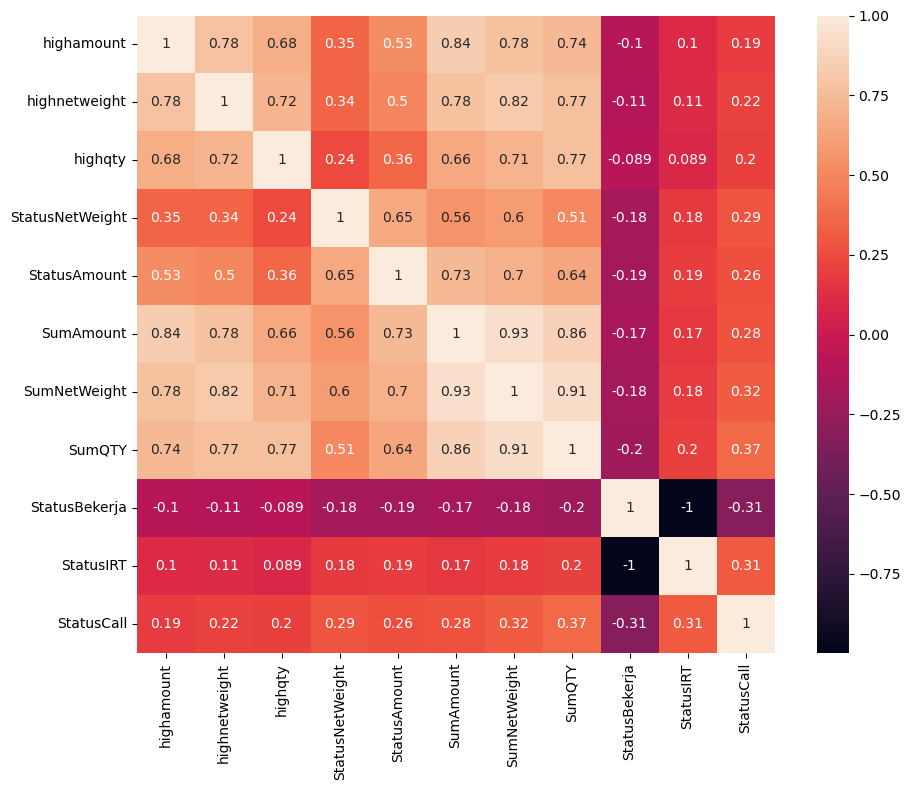

In [19]:
# Visualisasi korelasi lebih lanjut pada fitur yang berkorelasi tinggi
fitur_redundant = ['highamount', 'highnetweight', 'highqty', 'StatusNetWeight',
                   'StatusAmount','SumAmount', 'SumNetWeight', 'SumQTY', 'StatusBekerja', 'StatusIRT', 'StatusCall']

fig, ax = plt.subplots(figsize= (10, 8))

redundant = modelling[fitur_redundant]
ax = sns.heatmap(redundant.corr(), annot=True, square=True)

plt.tight_layout()
plt.show()

### Model Training & Evaluation

In [20]:
# Memisahkan Fitur & Target
X = modelling.drop(drop_features, axis=1)
y = modelling['StatusCall']

# Melakukan splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42)

# Model Evaluation : Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_reg = log_reg.predict(X_test)
y_proba_reg = log_reg.predict_proba(X_test)
precision_reg, recall_reg, _ = precision_recall_curve(y_test, y_proba_reg[:, 1])

print("Logistic Regression")
print("Accuracy (Test Set): %.4f" % accuracy_score(y_test, y_pred_reg))
print("Precision (Test Set): %.4f" % precision_score(y_test, y_pred_reg))
print("Sensitivity (Test Set): %.4f" % recall_score(y_test, y_pred_reg))
print("Specificity (Test Set): %.4f" % recall_score(y_test, y_pred_reg, pos_label=0))
print("roc_auc (test-proba): %.4f" % roc_auc_score(y_test, y_pred_reg))
print("PRC AUC (test-proba): %.4f" % auc(recall_reg, precision_reg))

# Model Evaluation : XGBoost
xgb_classifier = xgb.XGBClassifier(random_state=42)
xgb_classifier.fit(X_train, y_train)
y_pred_xgb = xgb_classifier.predict(X_test)
y_proba_xgb = xgb_classifier.predict_proba(X_test)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_proba_xgb[:, 1])

print('----------')
print("XGBoost")
print("Accuracy (Test Set): %.4f" % accuracy_score(y_test, y_pred_xgb))
print("Precision (Test Set): %.4f" % precision_score(y_test, y_pred_xgb))
print("Sensitivity (Test Set): %.4f" % recall_score(y_test, y_pred_xgb))
print("Specificity (Test Set): %.4f" % recall_score(np.logical_not(y_test), np.logical_not(y_pred_xgb)))
print("roc_auc (test-proba): %.4f" % roc_auc_score(y_test, y_proba_xgb[:, 1]))
print("PRC AUC (test-proba): %.4f" % auc(recall_xgb, precision_xgb))

Logistic Regression
Accuracy (Test Set): 0.4304
Precision (Test Set): 0.4420
Sensitivity (Test Set): 0.9406
Specificity (Test Set): 0.0015
roc_auc (test-proba): 0.4711
PRC AUC (test-proba): 0.6617
----------
XGBoost
Accuracy (Test Set): 0.8033
Precision (Test Set): 0.7629
Sensitivity (Test Set): 0.8261
Specificity (Test Set): 0.7841
roc_auc (test-proba): 0.8867
PRC AUC (test-proba): 0.8589


### Cek Signifikansi

In [21]:
import statsmodels.api as sm

model = sm.OLS(y, X).fit(alpha = 0.95)  # Menggunakan alpha = 0.05
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:             StatusCall   R-squared (uncentered):                   0.611
Model:                            OLS   Adj. R-squared (uncentered):              0.611
Method:                 Least Squares   F-statistic:                              6717.
Date:                Mon, 15 Jan 2024   Prob (F-statistic):                        0.00
Time:                        16:38:18   Log-Likelihood:                         -75634.
No. Observations:              137042   AIC:                                  1.513e+05
Df Residuals:                  137010   BIC:                                  1.516e+05
Df Model:                          32                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

### Feature Importance

In [22]:
# Mengambil nama kolom
cols = modelling.drop(drop_features, axis=1).columns

# Get feature importances from the trained model
feature_importances = xgb_classifier.feature_importances_

# Create a DataFrame for better visualization (optional)
feature_importance_df = pd.DataFrame({'Feature': cols, 'Importance': feature_importances})

# Sort the DataFrame by importance values
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

In [23]:
joblib.dump(xgb_classifier, r'D:/Roudhotul Maemanah/Portofolio/Predictive/Model XGB Success Call') 

['D:/Roudhotul Maemanah/Portofolio/Predictive/Model XGB Success Call']